<a href="https://colab.research.google.com/github/afss2/Projeto1_CD/blob/main/Projeto_TAGDI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [134]:
!pip install fancyimpute

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [135]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats

# Coleta de dados

In [136]:
#Realizando a importação do dataset dos jogadores da base de dados do FIFA 20, com 20 colunas

from google.colab import drive
drive.mount('/content/gdrive')
df = pd.read_csv('gdrive/MyDrive/ProjetoTAGDI/players_20.csv')

df.dataframeName = 'players_20.csv'

len(df)

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


18278

# Pré-processamento

Definição de Tipos

In [137]:
# Primeiro, iremos checar os tipos e realizar a categorização dos mesmos caso não esteja correto.

df.dtypes

short_name             object
age                     int64
dob                    object
height_cm               int64
nationality            object
club                   object
overall                 int64
potential               int64
value_eur               int64
wage_eur                int64
player_positions       object
release_clause_eur    float64
team_position          object
nation_position        object
pace                  float64
shooting              float64
passing               float64
dribbling             float64
defending             float64
physic                float64
dtype: object

In [138]:
# Agora imputando os novos tipos

df['nationality'] = df['nationality'].astype('category')
df['club'] = df['club'].astype('category')
df['player_positions'] = df['player_positions'].astype('category')
df['dob'] = df['dob'].astype('datetime64[ns]')

In [139]:
#Substituindo no dataframe pelos códigos e salvando num dict as categorias antes da substituição, para poder consultar os valores posteriormente

nat = dict(enumerate(df['nationality'].cat.categories))
df['nationality'] = df['nationality'].cat.codes

d = dict(enumerate(df['club'].cat.categories))
df['club'] = df['club'].cat.codes

In [140]:
#Após a mudança de tipos, assim ficou o dataframe
df.dtypes

short_name                    object
age                            int64
dob                   datetime64[ns]
height_cm                      int64
nationality                    int16
club                           int16
overall                        int64
potential                      int64
value_eur                      int64
wage_eur                       int64
player_positions            category
release_clause_eur           float64
team_position                 object
nation_position               object
pace                         float64
shooting                     float64
passing                      float64
dribbling                    float64
defending                    float64
physic                       float64
dtype: object

Tratamento de dados ausentes

In [141]:
# Após ajustar corretamente os tipos, vamos checar se há algum dado ausente:
print(df.isnull().sum())

short_name                0
age                       0
dob                       0
height_cm                 0
nationality               0
club                      0
overall                   0
potential                 0
value_eur                 0
wage_eur                  0
player_positions          0
release_clause_eur     1298
team_position           240
nation_position       17152
pace                   2036
shooting               2036
passing                2036
dribbling              2036
defending              2036
physic                 2036
dtype: int64


In [142]:
#Como obtivemos exatamente 2036 jogadores com os atributos 'pace', 'shooting', 'passing', 'dribbling', 'defending' e 'physic' ausentes, suspeitamos que houvesse algo em comum entre eles.
#Pelo nosso conhecimento do domínio, suspeitamos que se tratavam de goleiros. Testamos a hipótese e obtivemos a confirmação
dfs = df[(df['pace'].isnull()) & (df['shooting'].isnull()) & (df['passing'].isnull()) & (df['dribbling'].isnull()) & (df['defending'].isnull()) & (df['physic'].isnull()) & (df['player_positions'] == 'GK')]

print(len(dfs))


2036


In [143]:
#Decidimos imputar a mediana dos valores das colunas vazias dos goleiros. Preferimos a mediana no lugar de média para reduzir a influência dos outliers
df['pace'].fillna(df['pace'].median(), inplace=True);
df['shooting'].fillna(df['shooting'].median(), inplace=True);
df['passing'].fillna(df['passing'].median(), inplace=True);
df['dribbling'].fillna(df['dribbling'].median(), inplace=True);
df['defending'].fillna(df['defending'].median(), inplace=True);
df['physic'].fillna(df['physic'].median(), inplace=True);



In [144]:
print(df.isnull().sum())
df.head()

short_name                0
age                       0
dob                       0
height_cm                 0
nationality               0
club                      0
overall                   0
potential                 0
value_eur                 0
wage_eur                  0
player_positions          0
release_clause_eur     1298
team_position           240
nation_position       17152
pace                      0
shooting                  0
passing                   0
dribbling                 0
defending                 0
physic                    0
dtype: int64


,short_name,age,dob,height_cm,nationality,club,overall,potential,value_eur,wage_eur,player_positions,release_clause_eur,team_position,nation_position,pace,shooting,passing,dribbling,defending,physic
0,L. Messi,32,1987-06-24,170,5,223,94,94,95500000,565000,"RW, CF, ST",195800000.0,RW,NaN,87.0,92.0,92.0,96.0,39.0,66.0
1,Cristiano Ronaldo,34,1985-02-05,187,121,349,93,93,58500000,405000,"ST, LW",96500000.0,LW,LS,90.0,93.0,82.0,89.0,35.0,78.0
2,Neymar Jr,27,1992-02-05,175,18,461,92,92,105500000,290000,"LW, CAM",195200000.0,CAM,LW,91.0,85.0,87.0,95.0,32.0,58.0
3,J. Oblak,26,1993-01-07,188,133,62,91,93,77500000,125000,GK,164700000.0,GK,GK,69.0,54.0,58.0,64.0,56.0,66.0
4,E. Hazard,28,1991-01-07,175,12,504,91,91,90000000,470000,"LW, CF",184500000.0,LW,LF,91.0,83.0,86.0,94.0,35.0,66.0


In [145]:
#Vemos que a coluna com mais dados ausentes é a 'nation_position', pelo conhecimento do domínio sabemos que nem todos os jogadores atuam pela seleção de seu país. 
#Como temos muitos valores ausentes e já temos as colunas players_positions e team_position, ela acabam se tornando mais relevantes e por isso decidimos remover a coluna 'nation_position'
df = df.drop(columns=['nation_position', 'team_position'])
df.head()

,short_name,age,dob,height_cm,nationality,club,overall,potential,value_eur,wage_eur,player_positions,release_clause_eur,pace,shooting,passing,dribbling,defending,physic
0,L. Messi,32,1987-06-24,170,5,223,94,94,95500000,565000,"RW, CF, ST",195800000.0,87.0,92.0,92.0,96.0,39.0,66.0
1,Cristiano Ronaldo,34,1985-02-05,187,121,349,93,93,58500000,405000,"ST, LW",96500000.0,90.0,93.0,82.0,89.0,35.0,78.0
2,Neymar Jr,27,1992-02-05,175,18,461,92,92,105500000,290000,"LW, CAM",195200000.0,91.0,85.0,87.0,95.0,32.0,58.0
3,J. Oblak,26,1993-01-07,188,133,62,91,93,77500000,125000,GK,164700000.0,69.0,54.0,58.0,64.0,56.0,66.0
4,E. Hazard,28,1991-01-07,175,12,504,91,91,90000000,470000,"LW, CF",184500000.0,91.0,83.0,86.0,94.0,35.0,66.0


In [146]:
# Aqui, fazemos mais algumas alterações no dataframe (drop das colunas short_name e player_positions) para poder utilizar o KNN para imputar os valores nulos restantes

# Salvando as informações para adicionar posteriormente
short_name_column = df['short_name'];
player_positions_column = df['player_positions'];

df = df.drop(columns=['short_name', 'player_positions']);


df['dob'] = df['dob'].values.astype("float64");

In [147]:
# Aqui utilizamos o KNN com 3 vizinhos para realizar a imputação

from fancyimpute import KNN
fit_knn = KNN(k=3).fit_transform(df)

fit_knn.shape

Imputing row 1/18278 with 0 missing, elapsed time: 90.773
Imputing row 101/18278 with 0 missing, elapsed time: 90.774
Imputing row 201/18278 with 0 missing, elapsed time: 90.776
Imputing row 301/18278 with 0 missing, elapsed time: 90.776
Imputing row 401/18278 with 0 missing, elapsed time: 90.778
Imputing row 501/18278 with 0 missing, elapsed time: 90.779
Imputing row 601/18278 with 0 missing, elapsed time: 90.780
Imputing row 701/18278 with 0 missing, elapsed time: 90.781
Imputing row 801/18278 with 0 missing, elapsed time: 90.783
Imputing row 901/18278 with 0 missing, elapsed time: 90.784
Imputing row 1001/18278 with 0 missing, elapsed time: 90.786
Imputing row 1101/18278 with 0 missing, elapsed time: 90.789
Imputing row 1201/18278 with 0 missing, elapsed time: 90.790
Imputing row 1301/18278 with 0 missing, elapsed time: 90.792
Imputing row 1401/18278 with 0 missing, elapsed time: 90.794
Imputing row 1501/18278 with 0 missing, elapsed time: 90.796
Imputing row 1601/18278 with 0 missi

(18278, 16)

In [148]:
# Aqui fazemos a criação do dataframe utilizando os valores do KNN

imputed_df = pd.DataFrame(data=fit_knn[0:,0:],columns=['age',	'dob',	'height_cm',	'nationality',	'club',	'overall',	'potential',	'value_eur', 'wage_eur'	,'release_clause_eur',	'pace', 'shooting',	'passing', 'dribbling', 'defending', 'physic' ]) 

In [149]:
# E então, vemos que não há nenhum valor nulo

print(imputed_df.isnull().sum())

age                   0
dob                   0
height_cm             0
nationality           0
club                  0
overall               0
potential             0
value_eur             0
wage_eur              0
release_clause_eur    0
pace                  0
shooting              0
passing               0
dribbling             0
defending             0
physic                0
dtype: int64


In [150]:
imputed_df.describe()

,age,dob,height_cm,nationality,club,overall,potential,value_eur,wage_eur,release_clause_eur,pace,shooting,passing,dribbling,defending,physic
count,18278.000000,1.827800e+04,18278.000000,18278.000000,18278.000000,18278.000000,18278.000000,1.827800e+04,18278.000000,1.827800e+04,18278.000000,18278.000000,18278.000000,18278.000000,18278.000000,18278.000000
mean,25.283291,7.490673e+17,181.362184,74.997483,346.123810,66.244994,71.546887,2.484038e+06,9456.942773,4.572878e+06,67.845607,52.487854,57.319127,62.695153,52.048802,65.001805
std,4.656964,1.467489e+17,6.756961,47.086559,201.072795,6.949953,6.139669,5.585481e+06,21351.714095,1.070491e+07,10.657660,13.235769,9.813993,9.706187,15.541085,9.207275
min,16.000000,2.226528e+17,156.000000,0.000000,0.000000,48.000000,49.000000,0.000000e+00,0.000000,1.300000e+04,24.000000,15.000000,24.000000,23.000000,15.000000,27.000000
25%,22.000000,6.441120e+17,177.000000,38.000000,174.000000,62.000000,67.000000,3.250000e+05,1000.000000,5.660000e+05,63.000000,44.000000,52.000000,58.000000,39.000000,60.000000
50%,25.000000,7.612704e+17,181.000000,57.000000,346.000000,66.000000,71.000000,7.000000e+05,3000.000000,1.200000e+06,69.000000,54.000000,58.000000,64.000000,56.000000,66.000000
75%,29.000000,8.665920e+17,186.000000,123.000000,519.000000,71.000000,75.000000,2.100000e+06,8000.000000,3.500000e+06,74.000000,62.000000,63.000000,69.000000,64.000000,71.000000
max,42.000000,1.028765e+18,205.000000,161.000000,697.000000,94.000000,95.000000,1.055000e+08,565000.000000,1.958000e+08,96.000000,93.000000,92.000000,96.000000,90.000000,90.000000


Normalização e discretização

In [151]:
imputed_df.head()

,age,dob,height_cm,nationality,club,overall,potential,value_eur,wage_eur,release_clause_eur,pace,shooting,passing,dribbling,defending,physic
0,32.0,5.514912e+17,170.0,5.0,223.0,94.0,94.0,95500000.0,565000.0,195800000.0,87.0,92.0,92.0,96.0,39.0,66.0
1,34.0,4.764096e+17,187.0,121.0,349.0,93.0,93.0,58500000.0,405000.0,96500000.0,90.0,93.0,82.0,89.0,35.0,78.0
2,27.0,6.972480e+17,175.0,18.0,461.0,92.0,92.0,105500000.0,290000.0,195200000.0,91.0,85.0,87.0,95.0,32.0,58.0
3,26.0,7.263648e+17,188.0,133.0,62.0,91.0,93.0,77500000.0,125000.0,164700000.0,69.0,54.0,58.0,64.0,56.0,66.0
4,28.0,6.632064e+17,175.0,12.0,504.0,91.0,91.0,90000000.0,470000.0,184500000.0,91.0,83.0,86.0,94.0,35.0,66.0


In [152]:
# alguns valores, como a data de nascimento (convertida para float), valor de mercado, release clause e salário acabam dominando o cálculo.

dist = np.linalg.norm(imputed_df.values[1]-imputed_df.values[2])
print(dist)

2.208384e+17


In [153]:
imputed_df_norm = (imputed_df - imputed_df.min()) / (imputed_df.max() - imputed_df.min())
print(imputed_df_norm.head())

        age       dob  height_cm  nationality      club   overall  potential  \
0  0.615385  0.407931   0.285714     0.031056  0.319943  1.000000   0.978261   
1  0.692308  0.314791   0.632653     0.751553  0.500717  0.978261   0.956522   
2  0.423077  0.588746   0.387755     0.111801  0.661406  0.956522   0.934783   
3  0.384615  0.624866   0.653061     0.826087  0.088953  0.934783   0.956522   
4  0.461538  0.546517   0.387755     0.074534  0.723099  0.934783   0.913043   

   value_eur  wage_eur  release_clause_eur      pace  shooting   passing  \
0   0.905213  1.000000            1.000000  0.875000  0.987179  1.000000   
1   0.554502  0.716814            0.492816  0.916667  1.000000  0.852941   
2   1.000000  0.513274            0.996935  0.930556  0.897436  0.926471   
3   0.734597  0.221239            0.841154  0.625000  0.500000  0.500000   
4   0.853081  0.831858            0.942284  0.930556  0.871795  0.911765   

   dribbling  defending    physic  
0   1.000000   0.320000  0

In [154]:
# recalculando a distância
imputed_df_norm.drop(columns=['dob','club','nationality'])
dist = np.linalg.norm(imputed_df_norm.values[3]-imputed_df_norm.values[4])
print(dist)

1.44805437965041


In [155]:
# Agora fazendo a discretização de algumas colunas importantes:

imputed_df['age_dist'] = pd.qcut(imputed_df['age'],4)
imputed_df['overall_dist'] = pd.qcut(imputed_df['overall'],4)
imputed_df['potential_dist'] = pd.qcut(imputed_df['potential'],4)
imputed_df['wage_eur_dist'] = pd.qcut(imputed_df['wage_eur'],4)
imputed_df['value_eur_dist'] = pd.qcut(imputed_df['value_eur'],4)


In [156]:
imputed_df['overall'].describe()

count    18278.000000
mean        66.244994
std          6.949953
min         48.000000
25%         62.000000
50%         66.000000
75%         71.000000
max         94.000000
Name: overall, dtype: float64

In [157]:
imputed_df['overall_dist'].value_counts()

(47.999, 62.0]    5174
(66.0, 71.0]      4714
(62.0, 66.0]      4349
(71.0, 94.0]      4041
Name: overall_dist, dtype: int64

Limpeza de dados

(Univariado)

In [158]:
#Verificando que não possui instâncias duplicadas
imputed_df[imputed_df.duplicated()].sort_values("release_clause_eur").head()

,age,dob,height_cm,nationality,club,overall,potential,value_eur,wage_eur,release_clause_eur,...,shooting,passing,dribbling,defending,physic,age_dist,overall_dist,potential_dist,wage_eur_dist,value_eur_dist


In [159]:
imputed_df["release_clause_eur"].describe()

count    1.827800e+04
mean     4.572878e+06
std      1.070491e+07
min      1.300000e+04
25%      5.660000e+05
50%      1.200000e+06
75%      3.500000e+06
max      1.958000e+08
Name: release_clause_eur, dtype: float64

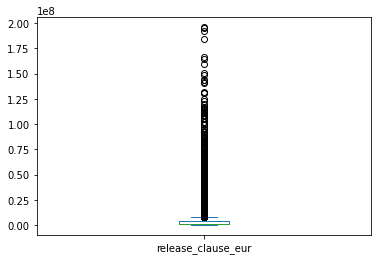

In [160]:
imputed_df["release_clause_eur"].plot.box()

In [161]:
len(imputed_df)

18278

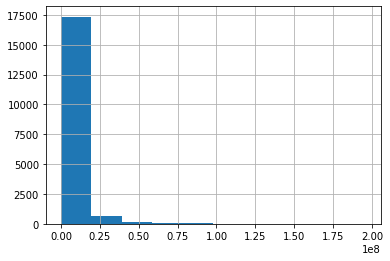

In [162]:
imputed_df["release_clause_eur"].hist()

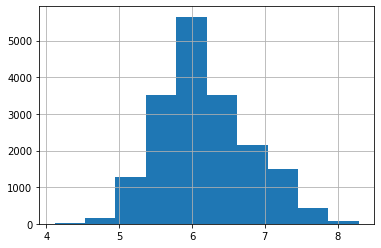

In [163]:
from numpy import log10
imputed_df['release_clause_eur_log'] = log10(imputed_df['release_clause_eur'])
imputed_df['release_clause_eur_log'].hist()

In [164]:
from numpy import abs
mad = abs(imputed_df['release_clause_eur_log'] - imputed_df['release_clause_eur_log'].median()).median()*(1/0.6745)
print(mad)

0.5649825061886359


In [165]:
imputed_df['release_clause_eur_log'].mad()

0.48688771737207304

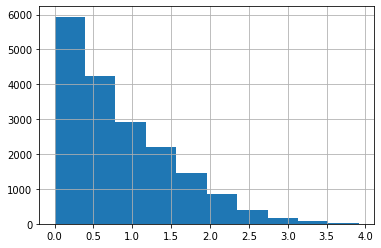

In [166]:
(abs(imputed_df['release_clause_eur_log']-imputed_df['release_clause_eur_log'].median())/mad).hist()

In [167]:
len(imputed_df)

18278

In [168]:
imputed_df[abs(imputed_df['release_clause_eur_log']-imputed_df['release_clause_eur_log'].median())/mad > 3.0]

,age,dob,height_cm,nationality,club,overall,potential,value_eur,wage_eur,release_clause_eur,...,passing,dribbling,defending,physic,age_dist,overall_dist,potential_dist,wage_eur_dist,value_eur_dist,release_clause_eur_log
0,32.0,5.514912e+17,170.0,5.0,223.0,94.0,94.0,95500000.0,565000.0,195800000.0,...,92.0,96.0,39.0,66.0,"(29.0, 42.0]","(71.0, 94.0]","(75.0, 95.0]","(8000.0, 565000.0]","(2100000.0, 105500000.0]",8.291813
1,34.0,4.764096e+17,187.0,121.0,349.0,93.0,93.0,58500000.0,405000.0,96500000.0,...,82.0,89.0,35.0,78.0,"(29.0, 42.0]","(71.0, 94.0]","(75.0, 95.0]","(8000.0, 565000.0]","(2100000.0, 105500000.0]",7.984527
2,27.0,6.972480e+17,175.0,18.0,461.0,92.0,92.0,105500000.0,290000.0,195200000.0,...,87.0,95.0,32.0,58.0,"(25.0, 29.0]","(71.0, 94.0]","(75.0, 95.0]","(8000.0, 565000.0]","(2100000.0, 105500000.0]",8.290480
3,26.0,7.263648e+17,188.0,133.0,62.0,91.0,93.0,77500000.0,125000.0,164700000.0,...,58.0,64.0,56.0,66.0,"(25.0, 29.0]","(71.0, 94.0]","(75.0, 95.0]","(8000.0, 565000.0]","(2100000.0, 105500000.0]",8.216694
4,28.0,6.632064e+17,175.0,12.0,504.0,91.0,91.0,90000000.0,470000.0,184500000.0,...,86.0,94.0,35.0,66.0,"(25.0, 29.0]","(71.0, 94.0]","(75.0, 95.0]","(8000.0, 565000.0]","(2100000.0, 105500000.0]",8.265996
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16693,39.0,3.046464e+17,188.0,23.0,14.0,57.0,57.0,10000.0,1000.0,13000.0,...,58.0,64.0,56.0,66.0,"(29.0, 42.0]","(47.999, 62.0]","(48.999, 67.0]","(-0.001, 1000.0]","(-0.001, 325000.0]",4.113943
16733,18.0,9.633600e+17,187.0,45.0,25.0,56.0,75.0,160000.0,1000.0,60200000.0,...,58.0,64.0,56.0,66.0,"(15.999, 22.0]","(47.999, 62.0]","(71.0, 75.0]","(-0.001, 1000.0]","(-0.001, 325000.0]",7.779596
17347,36.0,4.209408e+17,185.0,80.0,667.0,55.0,55.0,10000.0,1000.0,13000.0,...,58.0,64.0,56.0,66.0,"(29.0, 42.0]","(47.999, 62.0]","(48.999, 67.0]","(-0.001, 1000.0]","(-0.001, 325000.0]",4.113943
17946,36.0,4.102272e+17,196.0,45.0,387.0,52.0,52.0,10000.0,1000.0,18000.0,...,30.0,23.0,50.0,57.0,"(29.0, 42.0]","(47.999, 62.0]","(48.999, 67.0]","(-0.001, 1000.0]","(-0.001, 325000.0]",4.255273


In [169]:
imputed_df = imputed_df[abs(imputed_df['release_clause_eur_log']-imputed_df['release_clause_eur_log'].median())/mad < 3.5]
print(len(imputed_df))

18255


(Bivariado)

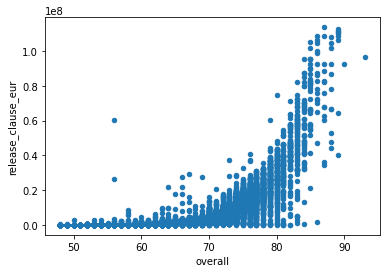

In [170]:
imputed_df.plot.scatter(x='overall',y='release_clause_eur')

In [171]:
imputed_df['release_clause_per_overall'] = imputed_df['release_clause_eur'] / imputed_df['overall']

In [172]:
imputed_df['release_clause_per_overall'].describe()

count    1.825500e+04
mean     5.852865e+04
std      1.147021e+05
min      2.280702e+02
25%      9.032002e+03
50%      1.846154e+04
75%      4.937979e+04
max      1.306897e+06
Name: release_clause_per_overall, dtype: float64

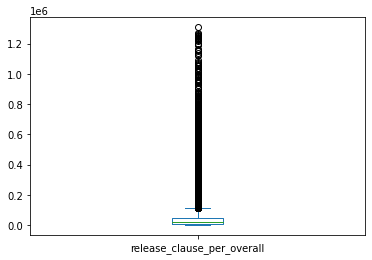

In [173]:
imputed_df['release_clause_per_overall'].plot.box()

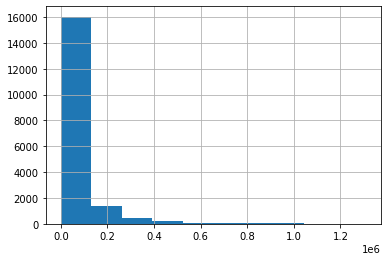

In [174]:
imputed_df['release_clause_per_overall'].hist()

In [175]:
imputed_df['release_clause_per_overall'] = log10(imputed_df['release_clause_per_overall'])

In [176]:
mad = abs(imputed_df['release_clause_per_overall'] - imputed_df['release_clause_per_overall'].median()).median()*(1/0.6745)

In [177]:
imputed_df['release_clause_per_overall'].mad()

0.4534979632980097

In [178]:
((abs(imputed_df['release_clause_per_overall']-imputed_df['release_clause_per_overall'].median()))/mad).describe()

count    18255.000000
mean         0.853669
std          0.692912
min          0.000000
25%          0.288039
50%          0.674500
75%          1.272213
max          3.633531
Name: release_clause_per_overall, dtype: float64

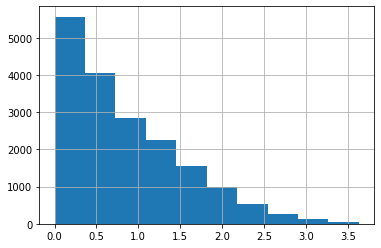

In [179]:
(abs(imputed_df['release_clause_per_overall']-imputed_df['release_clause_per_overall'].median())/mad).hist()

In [180]:
imputed_df[abs(imputed_df['release_clause_per_overall']-imputed_df['release_clause_per_overall'].median())/mad > 2.5]

,age,dob,height_cm,nationality,club,overall,potential,value_eur,wage_eur,release_clause_eur,...,dribbling,defending,physic,age_dist,overall_dist,potential_dist,wage_eur_dist,value_eur_dist,release_clause_eur_log,release_clause_per_overall
1,34.0,4.764096e+17,187.0,121.0,349.0,93.0,93.0,58500000.0,405000.0,96500000.0,...,89.0,35.0,78.0,"(29.0, 42.0]","(71.0, 94.0]","(75.0, 95.0]","(8000.0, 565000.0]","(2100000.0, 105500000.0]",7.984527,6.016044
8,33.0,4.950720e+17,172.0,34.0,504.0,90.0,90.0,45000000.0,340000.0,92300000.0,...,89.0,72.0,66.0,"(29.0, 42.0]","(71.0, 94.0]","(75.0, 95.0]","(8000.0, 565000.0]","(2100000.0, 105500000.0]",7.965202,6.010959
13,26.0,7.179840e+17,191.0,18.0,388.0,89.0,91.0,58000000.0,155000.0,111700000.0,...,64.0,56.0,66.0,"(25.0, 29.0]","(71.0, 94.0]","(75.0, 95.0]","(8000.0, 565000.0]","(2100000.0, 105500000.0]",8.048053,6.098663
14,28.0,6.579360e+17,192.0,136.0,400.0,89.0,90.0,56000000.0,205000.0,110600000.0,...,64.0,56.0,66.0,"(25.0, 29.0]","(71.0, 94.0]","(75.0, 95.0]","(8000.0, 565000.0]","(2100000.0, 105500000.0]",8.043755,6.094365
16,34.0,4.612896e+17,187.0,77.0,349.0,89.0,89.0,24500000.0,215000.0,40400000.0,...,60.0,90.0,82.0,"(29.0, 42.0]","(71.0, 94.0]","(75.0, 95.0]","(8000.0, 565000.0]","(2100000.0, 105500000.0]",7.606381,5.656991
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18164,25.0,7.556544e+17,183.0,45.0,696.0,50.0,54.0,30000.0,1000.0,40000.0,...,64.0,56.0,66.0,"(22.0, 25.0]","(47.999, 62.0]","(48.999, 67.0]","(-0.001, 1000.0]","(-0.001, 325000.0]",4.602060,2.903090
18165,28.0,6.634656e+17,186.0,28.0,621.0,50.0,51.0,20000.0,2000.0,33000.0,...,64.0,56.0,66.0,"(25.0, 29.0]","(47.999, 62.0]","(48.999, 67.0]","(1000.0, 3000.0]","(-0.001, 325000.0]",4.518514,2.819544
18166,27.0,6.893856e+17,192.0,28.0,620.0,50.0,51.0,20000.0,2000.0,33000.0,...,64.0,56.0,66.0,"(25.0, 29.0]","(47.999, 62.0]","(48.999, 67.0]","(1000.0, 3000.0]","(-0.001, 325000.0]",4.518514,2.819544
18228,23.0,8.314272e+17,185.0,85.0,345.0,49.0,55.0,30000.0,1000.0,44000.0,...,64.0,56.0,66.0,"(22.0, 25.0]","(47.999, 62.0]","(48.999, 67.0]","(-0.001, 1000.0]","(-0.001, 325000.0]",4.643453,2.953257


In [181]:
imputed_df = imputed_df[abs(imputed_df['release_clause_per_overall']-imputed_df['release_clause_per_overall'].median())/mad < 2.5]
print(len(imputed_df))

17766


(Multivariado)

In [182]:
cleaned_df = imputed_df

cleaned_df = cleaned_df.drop(columns=['age_dist', 'overall_dist', 'potential_dist', 'wage_eur_dist', 'value_eur_dist'])

cleaned_df.head()

,age,dob,height_cm,nationality,club,overall,potential,value_eur,wage_eur,release_clause_eur,pace,shooting,passing,dribbling,defending,physic,release_clause_eur_log,release_clause_per_overall
68,27.0,7.083072e+17,172.0,18.0,225.0,86.0,86.0,46500000.0,175000.0,1.963597e+06,79.0,80.0,84.0,90.0,52.0,64.0,6.293052,4.358554
96,37.0,3.709152e+17,195.0,141.0,369.0,85.0,85.0,14000000.0,15000.0,2.100000e+07,56.0,88.0,77.0,77.0,34.0,78.0,7.322219,5.392800
128,36.0,4.150656e+17,188.0,121.0,248.0,84.0,84.0,6500000.0,16000.0,1.300000e+07,67.0,51.0,57.0,60.0,85.0,85.0,7.113943,5.189664
140,30.0,6.023808e+17,186.0,34.0,225.0,84.0,84.0,29500000.0,135000.0,6.160000e+05,84.0,80.0,78.0,82.0,62.0,77.0,5.789581,3.865301
159,23.0,8.290080e+17,177.0,5.0,626.0,83.0,89.0,35000000.0,105000.0,9.218005e+05,77.0,78.0,82.0,85.0,65.0,72.0,5.964637,4.045559


In [183]:
from sklearn.covariance import EllipticEnvelope
detector = EllipticEnvelope(contamination=0.01)
detector.fit(cleaned_df)

/usr/local/lib/python3.7/dist-packages/sklearn/covariance/_robust_covariance.py:189: RuntimeWarning: Determinant has increased; this should not happen: log(det) > log(previous_det) (180.777522130513319 > 180.675355386622897). You may want to try with a higher value of support_fraction (current value: 0.502).
  RuntimeWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/covariance/_robust_covariance.py:189: RuntimeWarning: Determinant has increased; this should not happen: log(det) > log(previous_det) (180.661221391353536 > 180.588051462877388). You may want to try with a higher value of support_fraction (current value: 0.502).
  RuntimeWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/covariance/_robust_covariance.py:189: RuntimeWarning: Determinant has increased; this should not happen: log(det) > log(previous_det) (180.795885452862109 > 180.659267535992996). You may want to try with a higher value of support_fraction (current value: 0.502).
  RuntimeWarning,
/usr/local/lib/p

EllipticEnvelope(contamination=0.01)

In [184]:
scores = detector.predict(cleaned_df)

In [185]:
scores

array([ 1, -1,  1, ...,  1,  1,  1])

In [186]:
cleaned_df['outlier'] = scores
print(cleaned_df.head())

      age           dob  height_cm  nationality   club  overall  potential  \
68   27.0  7.083072e+17      172.0         18.0  225.0     86.0       86.0   
96   37.0  3.709152e+17      195.0        141.0  369.0     85.0       85.0   
128  36.0  4.150656e+17      188.0        121.0  248.0     84.0       84.0   
140  30.0  6.023808e+17      186.0         34.0  225.0     84.0       84.0   
159  23.0  8.290080e+17      177.0          5.0  626.0     83.0       89.0   

      value_eur  wage_eur  release_clause_eur  pace  shooting  passing  \
68   46500000.0  175000.0        1.963597e+06  79.0      80.0     84.0   
96   14000000.0   15000.0        2.100000e+07  56.0      88.0     77.0   
128   6500000.0   16000.0        1.300000e+07  67.0      51.0     57.0   
140  29500000.0  135000.0        6.160000e+05  84.0      80.0     78.0   
159  35000000.0  105000.0        9.218005e+05  77.0      78.0     82.0   

     dribbling  defending  physic  release_clause_eur_log  \
68        90.0       52.0

In [187]:
cleaned_df[cleaned_df['outlier'] == -1]

,age,dob,height_cm,nationality,club,overall,potential,value_eur,wage_eur,release_clause_eur,pace,shooting,passing,dribbling,defending,physic,release_clause_eur_log,release_clause_per_overall,outlier
96,37.0,3.709152e+17,195.0,141.0,369.0,85.0,85.0,14000000.0,15000.0,2.100000e+07,56.0,88.0,77.0,77.0,34.0,78.0,7.322219,5.392800,-1
200,41.0,2.547936e+17,192.0,77.0,349.0,83.0,83.0,2600000.0,58000.0,4.300000e+06,69.0,54.0,58.0,64.0,56.0,66.0,6.633468,4.714390,-1
201,38.0,3.591648e+17,185.0,136.0,248.0,83.0,83.0,2600000.0,11000.0,5.200000e+06,69.0,54.0,58.0,64.0,56.0,66.0,6.716003,4.796925,-1
286,36.0,3.996000e+17,188.0,136.0,408.0,82.0,82.0,3700000.0,26000.0,6.400000e+06,69.0,54.0,58.0,64.0,56.0,66.0,6.806180,4.892366,-1
288,38.0,3.506976e+17,182.0,136.0,57.0,82.0,82.0,8000000.0,29000.0,1.680000e+07,61.0,82.0,64.0,75.0,49.0,74.0,7.225309,5.311495,-1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15868,38.0,3.525984e+17,182.0,72.0,339.0,59.0,59.0,0.0,0.0,4.501268e+05,59.0,36.0,54.0,55.0,59.0,63.0,5.653335,3.882483,-1
16314,40.0,2.885760e+17,180.0,45.0,419.0,58.0,58.0,0.0,1000.0,3.033974e+05,43.0,63.0,56.0,63.0,43.0,74.0,5.482012,3.718584,-1
16325,37.0,3.792096e+17,173.0,84.0,655.0,58.0,58.0,50000.0,1000.0,6.300000e+04,34.0,55.0,66.0,65.0,37.0,51.0,4.799341,3.035913,-1
16356,37.0,3.868992e+17,176.0,19.0,103.0,58.0,58.0,0.0,0.0,7.000000e+04,69.0,54.0,58.0,64.0,56.0,66.0,4.845098,3.081670,-1


In [188]:
cleaned_df.head()

,age,dob,height_cm,nationality,club,overall,potential,value_eur,wage_eur,release_clause_eur,pace,shooting,passing,dribbling,defending,physic,release_clause_eur_log,release_clause_per_overall,outlier
68,27.0,7.083072e+17,172.0,18.0,225.0,86.0,86.0,46500000.0,175000.0,1.963597e+06,79.0,80.0,84.0,90.0,52.0,64.0,6.293052,4.358554,1
96,37.0,3.709152e+17,195.0,141.0,369.0,85.0,85.0,14000000.0,15000.0,2.100000e+07,56.0,88.0,77.0,77.0,34.0,78.0,7.322219,5.392800,-1
128,36.0,4.150656e+17,188.0,121.0,248.0,84.0,84.0,6500000.0,16000.0,1.300000e+07,67.0,51.0,57.0,60.0,85.0,85.0,7.113943,5.189664,1
140,30.0,6.023808e+17,186.0,34.0,225.0,84.0,84.0,29500000.0,135000.0,6.160000e+05,84.0,80.0,78.0,82.0,62.0,77.0,5.789581,3.865301,1
159,23.0,8.290080e+17,177.0,5.0,626.0,83.0,89.0,35000000.0,105000.0,9.218005e+05,77.0,78.0,82.0,85.0,65.0,72.0,5.964637,4.045559,1


In [189]:
len(cleaned_df)

17766

In [190]:
cleaned_df = cleaned_df[cleaned_df['outlier'] != -1]
len(cleaned_df)

17588

In [191]:
# Adicionando algumas colunas novamente

cleaned_df.insert(0, 'short_name', short_name_column)
cleaned_df.insert(6, 'player_positions', player_positions_column)
print(cleaned_df)

         short_name   age           dob  height_cm  nationality   club  \
68         Coutinho  27.0  7.083072e+17      172.0         18.0  225.0   
128            Pepe  36.0  4.150656e+17      188.0        121.0  248.0   
140      I. Perišić  30.0  6.023808e+17      186.0         34.0  225.0   
159     G. Lo Celso  23.0  8.290080e+17      177.0          5.0  626.0   
187          Morata  26.0  7.197984e+17      189.0        136.0   62.0   
...             ...   ...           ...        ...          ...    ...   
18273    Shao Shuai  22.0  8.579520e+17      186.0         28.0   78.0   
18274  Xiao Mingjie  22.0  8.520768e+17      177.0         28.0  574.0   
18275     Zhang Wei  19.0  9.584352e+17      186.0         28.0  316.0   
18276  Wang Haijian  18.0  9.651744e+17      185.0         28.0  573.0   
18277    Pan Ximing  26.0  7.267104e+17      182.0         28.0  316.0   

      player_positions  overall  potential   value_eur  ...  \
68              LW, CM     86.0       86.0  4650

# Estatísticas descritivas

In [192]:
# 
cleaned_df['overall'].describe()

count    17588.000000
mean        65.795542
std          6.480972
min         48.000000
25%         62.000000
50%         66.000000
75%         70.000000
max         86.000000
Name: overall, dtype: float64

In [193]:
cleaned_df['potential'].describe()

count    17588.000000
mean        71.223903
std          5.736249
min         49.000000
25%         67.000000
50%         71.000000
75%         75.000000
max         89.000000
Name: potential, dtype: float64

In [194]:
# Calcular o overall de jogadores do Real Madrid

cleaned_df[cleaned_df['club'] == 504].describe()


,age,dob,height_cm,nationality,club,overall,potential,value_eur,wage_eur,release_clause_eur,pace,shooting,passing,dribbling,defending,physic,release_clause_eur_log,release_clause_per_overall,outlier
count,8.000000,8.000000e+00,8.000000,8.000000,8.0,8.00000,8.00000,8.000000e+00,8.000000,8.000000e+00,8.000000,8.000000,8.000000,8.000000,8.000000,8.000000,8.000000,8.000000,8.0
mean,20.625000,9.005040e+17,178.625000,114.250000,504.0,68.12500,81.75000,2.981250e+06,33875.000000,7.500000e+06,69.750000,54.125000,61.375000,68.875000,54.875000,60.125000,6.726387,4.893775,1.0
std,2.503569,7.895200e+16,5.527529,43.548823,0.0,4.12094,3.84522,2.676076e+06,26583.762498,6.585265e+06,9.528154,8.741322,5.475595,8.131728,14.884676,9.991961,0.387206,0.362044,0.0
min,18.000000,7.298208e+17,171.000000,18.000000,504.0,62.00000,76.00000,5.500000e+05,6000.000000,1.700000e+06,57.000000,39.000000,50.000000,55.000000,29.000000,43.000000,6.230449,4.438057,1.0
25%,19.000000,8.856864e+17,174.500000,122.000000,504.0,65.75000,80.00000,1.075000e+06,19500.000000,2.825000e+06,62.750000,49.250000,61.000000,65.500000,46.500000,54.250000,6.448273,4.633702,1.0
50%,20.000000,9.215856e+17,179.000000,136.000000,504.0,67.50000,82.00000,1.750000e+06,24000.000000,4.650000e+06,69.000000,54.500000,62.000000,68.000000,59.000000,62.000000,6.653748,4.824552,1.0
75%,21.250000,9.380232e+17,182.000000,136.000000,504.0,70.75000,83.75000,4.400000e+06,39250.000000,1.080000e+07,78.500000,60.500000,63.750000,72.750000,65.250000,66.250000,7.028389,5.177258,1.0
max,26.000000,9.916128e+17,188.000000,136.000000,504.0,74.00000,87.00000,7.500000e+06,88000.000000,2.010000e+07,82.000000,66.000000,68.000000,81.000000,71.000000,74.000000,7.303196,5.439873,1.0


In [195]:
# Procurando o time com maior número de jogadores

cleaned_df['club'].value_counts().idxmax()



5.0

In [196]:
#O time FC Union Berlin é o que tem o maior número de jogadores (foi o primeiro a ser retornado)
cleaned_df[cleaned_df['club'] == 5]

,short_name,age,dob,height_cm,nationality,club,player_positions,overall,potential,value_eur,...,release_clause_eur,pace,shooting,passing,dribbling,defending,physic,release_clause_eur_log,release_clause_per_overall,outlier
1173,N. Subotić,30.0,5.977152e+17,193.0,130.0,5.0,CB,77.0,77.0,7000000.0,...,1.260000e+07,50.0,45.0,52.0,47.0,80.0,76.0,7.100371,5.213880,1
2022,R. Gikiewicz,31.0,5.622048e+17,190.0,120.0,5.0,GK,75.0,75.0,4300000.0,...,7.700000e+06,69.0,54.0,58.0,64.0,56.0,66.0,6.886491,5.011429,1
2355,F. Hübner,28.0,6.677856e+17,193.0,57.0,5.0,CB,74.0,75.0,5500000.0,...,1.030000e+07,53.0,43.0,48.0,44.0,77.0,72.0,7.012837,5.143606,1
2692,M. Friedrich,23.0,8.188128e+17,192.0,57.0,5.0,CB,73.0,81.0,5500000.0,...,1.100000e+07,61.0,36.0,56.0,49.0,74.0,70.0,7.041393,5.178070,1
2995,C. Gentner,33.0,4.928256e+17,189.0,57.0,5.0,"CM, CDM, CAM",73.0,73.0,2300000.0,...,4.200000e+06,34.0,72.0,71.0,67.0,72.0,73.0,6.623249,4.759926,1
3122,S. Polter,28.0,6.704640e+17,192.0,57.0,5.0,ST,73.0,73.0,4100000.0,...,7.400000e+06,70.0,72.0,51.0,62.0,28.0,84.0,6.869232,5.005909,1
3148,A. Ujah,28.0,6.558624e+17,183.0,112.0,5.0,ST,73.0,73.0,4100000.0,...,7.400000e+06,69.0,72.0,55.0,69.0,33.0,72.0,6.869232,5.005909,1
3196,S. Andersson,27.0,6.795360e+17,190.0,141.0,5.0,ST,73.0,73.0,4300000.0,...,7.700000e+06,65.0,69.0,49.0,65.0,25.0,75.0,6.886491,5.023168,1
3710,K. Reichel,32.0,5.353344e+17,185.0,57.0,5.0,LB,72.0,72.0,1900000.0,...,3.500000e+06,68.0,68.0,66.0,67.0,71.0,75.0,6.544068,4.686736,1
3850,C. Trimmel,32.0,5.411232e+17,189.0,8.0,5.0,RB,72.0,72.0,1900000.0,...,3.500000e+06,73.0,59.0,67.0,67.0,68.0,79.0,6.544068,4.686736,1


In [197]:
# Agora vamos ver o clube que possui o maior número de jogadores com overall acima de 81.

print(cleaned_df[cleaned_df['overall'] > 81]['club'].value_counts().idxmax())
print(cleaned_df[cleaned_df['overall'] > 81][cleaned_df['club'] == 225])

# O clube é o FC Bayern Munchen, com 2 jogadores

225.0
     short_name   age           dob  height_cm  nationality   club  \
68     Coutinho  27.0  7.083072e+17      172.0         18.0  225.0   
140  I. Perišić  30.0  6.023808e+17      186.0         34.0  225.0   

    player_positions  overall  potential   value_eur  ...  release_clause_eur  \
68            LW, CM     86.0       86.0  46500000.0  ...        1.963597e+06   
140               LM     84.0       84.0  29500000.0  ...        6.160000e+05   

     pace  shooting  passing  dribbling  defending  physic  \
68   79.0      80.0     84.0       90.0       52.0    64.0   
140  84.0      80.0     78.0       82.0       62.0    77.0   

     release_clause_eur_log  release_clause_per_overall  outlier  
68                 6.293052                    4.358554        1  
140                5.789581                    3.865301        1  

[2 rows x 21 columns]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  after removing the cwd from sys.path.


In [198]:
# Vamos procurar o clube que possui a melhor média de jogadores que atuam como meio campo ofensivo (CAM)

grouped_df1 = cleaned_df[cleaned_df['player_positions'].str.contains('CAM')].groupby(['club'])['overall'].mean()
print(grouped_df1.idxmax())

#Temos como resultado a seleção do Uruguai


650.0


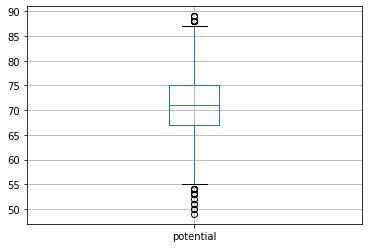

In [199]:
cleaned_df.boxplot(column=['potential'])

In [200]:
cleaned_df[cleaned_df['nationality'] == 18].cov()

,age,dob,height_cm,nationality,club,overall,potential,value_eur,wage_eur,release_clause_eur,pace,shooting,passing,dribbling,defending,physic,release_clause_eur_log,release_clause_per_overall,outlier
age,1.981717e+01,-6.212674e+17,-3.670893e-03,0.0,-2.302892e+02,5.266141e+00,-8.017281e+00,-1.666161e+06,4.535803e+03,-3.888461e+06,-5.994778e+00,5.526470e+00,6.690722e+00,-6.826862e-01,1.062433e+01,4.851039e+00,-3.778731e-01,-4.113155e-01,0.0
dob,-6.212674e+17,1.953065e+34,1.186999e+15,0.0,7.146201e+18,-1.676911e+17,2.489821e+17,5.093388e+22,-1.409697e+20,1.187635e+23,1.903943e+17,-1.779431e+17,-2.113058e+17,1.853640e+16,-3.301368e+17,-1.561437e+17,1.166803e+16,1.273252e+16,0.0
height_cm,-3.670893e-03,1.186999e+15,4.201133e+01,0.0,2.663390e+01,6.618647e-01,6.157991e-01,-2.520635e+05,-2.954537e+03,7.387616e+05,-3.733428e+01,-2.561126e+01,-2.495789e+01,-3.438786e+01,3.262975e+01,3.020515e+01,2.187510e-02,1.807776e-02,0.0
nationality,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0
club,-2.302892e+02,7.146201e+18,2.663390e+01,0.0,3.680822e+04,3.457562e+01,2.141812e+02,9.336626e+07,-9.368294e+04,1.886656e+08,1.328797e+02,1.702040e+01,-4.651550e+01,1.319757e+02,-1.606069e+02,8.426318e+01,1.263689e+01,1.244206e+01,0.0
overall,5.266141e+00,-1.676911e+17,6.618647e-01,0.0,3.457562e+01,2.159157e+01,1.570710e+01,1.274759e+07,4.072346e+04,2.208764e+07,6.249499e+00,1.664951e+01,2.047713e+01,1.639220e+01,2.380600e+01,1.614045e+01,2.005245e+00,1.871247e+00,0.0
potential,-8.017281e+00,2.489821e+17,6.157991e-01,0.0,2.141812e+02,1.570710e+01,2.409209e+01,1.233749e+07,3.219744e+04,2.256817e+07,1.005206e+01,8.606998e+00,1.342047e+01,1.509997e+01,1.674173e+01,9.417908e+00,2.005320e+00,1.908888e+00,0.0
value_eur,-1.666161e+06,5.093388e+22,-2.520635e+05,0.0,9.336626e+07,1.274759e+07,1.233749e+07,1.243163e+13,3.592438e+10,1.861935e+13,6.476767e+06,1.177614e+07,1.233852e+07,1.204135e+07,1.054865e+07,8.078903e+06,1.356178e+06,1.278986e+06,0.0
wage_eur,4.535803e+03,-1.409697e+20,-2.954537e+03,0.0,-9.368294e+04,4.072346e+04,3.219744e+04,3.592438e+10,1.907149e+08,4.790714e+10,1.270174e+04,3.630342e+04,4.548327e+04,3.670679e+04,4.683474e+04,2.340939e+04,3.765462e+03,3.518313e+03,0.0
release_clause_eur,-3.888461e+06,1.187635e+23,7.387616e+05,0.0,1.886656e+08,2.208764e+07,2.256817e+07,1.861935e+13,4.790714e+10,3.736536e+13,1.033463e+07,1.744339e+07,1.997378e+07,1.915168e+07,2.303981e+07,1.494033e+07,2.679819e+06,2.545311e+06,0.0


In [201]:
cleaned_df[cleaned_df['nationality'] == 18].corr(method='pearson')

,age,dob,height_cm,nationality,club,overall,potential,value_eur,wage_eur,release_clause_eur,pace,shooting,passing,dribbling,defending,physic,release_clause_eur_log,release_clause_per_overall,outlier
age,1.000000,-0.998618,-0.000127,NaN,-0.269638,0.254583,-0.366918,-0.106153,0.073780,-0.142897,-0.123430,0.101786,0.168263,-0.015707,0.131228,0.120856,-0.169289,-0.193754,NaN
dob,-0.998618,1.000000,0.001310,NaN,0.266529,-0.258232,0.362971,0.103368,-0.073042,0.139024,0.124872,-0.104396,-0.169274,0.013585,-0.129892,-0.123914,0.166511,0.191052,NaN
height_cm,-0.000127,0.001310,1.000000,NaN,0.021418,0.021976,0.019356,-0.011030,-0.033008,0.018646,-0.527952,-0.323973,-0.431083,-0.543401,0.276807,0.516836,0.006731,0.005849,NaN
nationality,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
club,-0.269638,0.266529,0.021418,NaN,1.000000,0.038784,0.227443,0.138024,-0.035359,0.160874,0.063483,0.007274,-0.027143,0.070456,-0.046030,0.048710,0.131362,0.135993,NaN
overall,0.254583,-0.258232,0.021976,NaN,0.038784,1.000000,0.688679,0.778076,0.634615,0.777629,0.123274,0.293779,0.493359,0.361321,0.281702,0.385237,0.860653,0.844472,NaN
potential,-0.366918,0.362971,0.019356,NaN,0.227443,0.688679,1.000000,0.712895,0.474998,0.752185,0.187710,0.143772,0.306102,0.315092,0.187546,0.212800,0.814797,0.815529,NaN
value_eur,-0.106153,0.103368,-0.011030,NaN,0.138024,0.778076,0.712895,1.000000,0.737790,0.863905,0.168370,0.273842,0.391773,0.349792,0.164505,0.254122,0.767106,0.760672,NaN
wage_eur,0.073780,-0.073042,-0.033008,NaN,-0.035359,0.634615,0.474998,0.737790,1.000000,0.567510,0.084303,0.215534,0.368719,0.272240,0.186475,0.187998,0.543787,0.534242,NaN
release_clause_eur,-0.142897,0.139024,0.018646,NaN,0.160874,0.777629,0.752185,0.863905,0.567510,1.000000,0.154964,0.233969,0.365815,0.320901,0.207248,0.271069,0.874327,0.873177,NaN


In [202]:
cleaned_df[cleaned_df['nationality'] == 18].corr(method='spearman')

,age,dob,height_cm,nationality,club,overall,potential,value_eur,wage_eur,release_clause_eur,pace,shooting,passing,dribbling,defending,physic,release_clause_eur_log,release_clause_per_overall,outlier
age,1.000000,-0.996675,-0.004620,NaN,-0.263783,0.222759,-0.339104,-0.137903,0.234762,-0.159354,-0.105275,0.079596,0.156551,-0.019240,0.147107,0.092413,-0.159354,-0.181992,NaN
dob,-0.996675,1.000000,0.003430,NaN,0.260701,-0.225602,0.335354,0.133869,-0.238167,0.155772,0.106864,-0.082333,-0.157500,0.018060,-0.146034,-0.096637,0.155772,0.178295,NaN
height_cm,-0.004620,0.003430,1.000000,NaN,0.033531,0.019540,0.037280,-0.010447,0.008448,0.006542,-0.537929,-0.311164,-0.441528,-0.585999,0.256039,0.495241,0.006542,0.005638,NaN
nationality,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
club,-0.263783,0.260701,0.033531,NaN,1.000000,0.037646,0.211011,0.140314,-0.110219,0.121442,0.062722,0.030341,-0.024192,0.060584,-0.053894,0.042439,0.121442,0.124514,NaN
overall,0.222759,-0.225602,0.019540,NaN,0.037646,1.000000,0.720539,0.910609,0.795246,0.883235,0.168481,0.295480,0.499499,0.396949,0.353060,0.365264,0.883235,0.869365,NaN
potential,-0.339104,0.335354,0.037280,NaN,0.211011,0.720539,1.000000,0.831453,0.502983,0.834963,0.199349,0.164523,0.311691,0.342635,0.238161,0.236298,0.834963,0.836502,NaN
value_eur,-0.137903,0.133869,-0.010447,NaN,0.140314,0.910609,0.831453,1.000000,0.719949,0.972955,0.219478,0.325347,0.455265,0.440451,0.243015,0.325010,0.972955,0.969013,NaN
wage_eur,0.234762,-0.238167,0.008448,NaN,-0.110219,0.795246,0.502983,0.719949,1.000000,0.693817,0.086779,0.242107,0.408302,0.289904,0.282189,0.251460,0.693817,0.682480,NaN
release_clause_eur,-0.159354,0.155772,0.006542,NaN,0.121442,0.883235,0.834963,0.972955,0.693817,1.000000,0.200792,0.278640,0.428278,0.410119,0.260434,0.309795,1.000000,0.999421,NaN


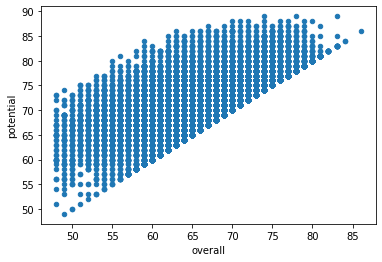

In [203]:
cleaned_df.plot.scatter(x='overall',y='potential')

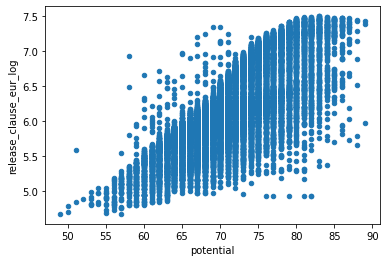

In [204]:
cleaned_df.plot.scatter(x='potential',y='release_clause_eur_log')

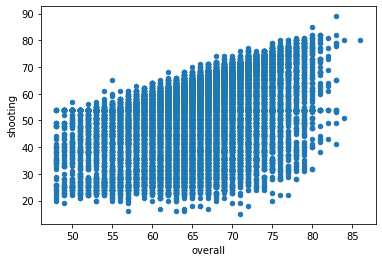

In [205]:
cleaned_df.plot.scatter(x='overall',y='shooting')

# Testes de hipótese

In [206]:
print(nat[18])

Brazil


In [207]:
cleaned_df.head()

,short_name,age,dob,height_cm,nationality,club,player_positions,overall,potential,value_eur,...,release_clause_eur,pace,shooting,passing,dribbling,defending,physic,release_clause_eur_log,release_clause_per_overall,outlier
68,Coutinho,27.0,7.083072e+17,172.0,18.0,225.0,"LW, CM",86.0,86.0,46500000.0,...,1.963597e+06,79.0,80.0,84.0,90.0,52.0,64.0,6.293052,4.358554,1
128,Pepe,36.0,4.150656e+17,188.0,121.0,248.0,CB,84.0,84.0,6500000.0,...,1.300000e+07,67.0,51.0,57.0,60.0,85.0,85.0,7.113943,5.189664,1
140,I. Perišić,30.0,6.023808e+17,186.0,34.0,225.0,LM,84.0,84.0,29500000.0,...,6.160000e+05,84.0,80.0,78.0,82.0,62.0,77.0,5.789581,3.865301,1
159,G. Lo Celso,23.0,8.290080e+17,177.0,5.0,626.0,"CM, CAM, CF",83.0,89.0,35000000.0,...,9.218005e+05,77.0,78.0,82.0,85.0,65.0,72.0,5.964637,4.045559,1
187,Morata,26.0,7.197984e+17,189.0,136.0,62.0,ST,83.0,85.0,32000000.0,...,5.098724e+06,81.0,79.0,71.0,80.0,31.0,72.0,6.707461,4.788383,1


In [208]:
cleaned_df['nationality'] 

68        18.0
128      121.0
140       34.0
159        5.0
187      136.0
         ...  
18273     28.0
18274     28.0
18275     28.0
18276     28.0
18277     28.0
Name: nationality, Length: 17588, dtype: float64

In [209]:
cleaned_df.dtypes

short_name                      object
age                            float64
dob                            float64
height_cm                      float64
nationality                    float64
club                           float64
player_positions              category
overall                        float64
potential                      float64
value_eur                      float64
wage_eur                       float64
release_clause_eur             float64
pace                           float64
shooting                       float64
passing                        float64
dribbling                      float64
defending                      float64
physic                         float64
release_clause_eur_log         float64
release_clause_per_overall     float64
outlier                          int64
dtype: object

In [210]:
print(nat)
codes = cleaned_df['nationality']
print(codes)
cleaned_df['nationality'] = codes.map(nat)
# print(ad)

{0: 'Afghanistan', 1: 'Albania', 2: 'Algeria', 3: 'Angola', 4: 'Antigua & Barbuda', 5: 'Argentina', 6: 'Armenia', 7: 'Australia', 8: 'Austria', 9: 'Azerbaijan', 10: 'Bahrain', 11: 'Barbados', 12: 'Belgium', 13: 'Belize', 14: 'Benin', 15: 'Bermuda', 16: 'Bolivia', 17: 'Bosnia Herzegovina', 18: 'Brazil', 19: 'Bulgaria', 20: 'Burkina Faso', 21: 'Burundi', 22: 'Cameroon', 23: 'Canada', 24: 'Cape Verde', 25: 'Central African Rep.', 26: 'Chad', 27: 'Chile', 28: 'China PR', 29: 'Chinese Taipei', 30: 'Colombia', 31: 'Comoros', 32: 'Congo', 33: 'Costa Rica', 34: 'Croatia', 35: 'Cuba', 36: 'Curacao', 37: 'Cyprus', 38: 'Czech Republic', 39: 'DR Congo', 40: 'Denmark', 41: 'Dominican Republic', 42: 'Ecuador', 43: 'Egypt', 44: 'El Salvador', 45: 'England', 46: 'Equatorial Guinea', 47: 'Eritrea', 48: 'Estonia', 49: 'Ethiopia', 50: 'FYR Macedonia', 51: 'Faroe Islands', 52: 'Finland', 53: 'France', 54: 'Gabon', 55: 'Gambia', 56: 'Georgia', 57: 'Germany', 58: 'Ghana', 59: 'Gibraltar', 60: 'Greece', 61: 

In [211]:
cleaned_df.head(15)

,short_name,age,dob,height_cm,nationality,club,player_positions,overall,potential,value_eur,...,release_clause_eur,pace,shooting,passing,dribbling,defending,physic,release_clause_eur_log,release_clause_per_overall,outlier
68,Coutinho,27.0,7.083072e+17,172.0,Brazil,225.0,"LW, CM",86.0,86.0,46500000.0,...,1.963597e+06,79.0,80.0,84.0,90.0,52.0,64.0,6.293052,4.358554,1
128,Pepe,36.0,4.150656e+17,188.0,Portugal,248.0,CB,84.0,84.0,6500000.0,...,1.300000e+07,67.0,51.0,57.0,60.0,85.0,85.0,7.113943,5.189664,1
140,I. Perišić,30.0,6.023808e+17,186.0,Croatia,225.0,LM,84.0,84.0,29500000.0,...,6.160000e+05,84.0,80.0,78.0,82.0,62.0,77.0,5.789581,3.865301,1
159,G. Lo Celso,23.0,8.290080e+17,177.0,Argentina,626.0,"CM, CAM, CF",83.0,89.0,35000000.0,...,9.218005e+05,77.0,78.0,82.0,85.0,65.0,72.0,5.964637,4.045559,1
187,Morata,26.0,7.197984e+17,189.0,Spain,62.0,ST,83.0,85.0,32000000.0,...,5.098724e+06,81.0,79.0,71.0,80.0,31.0,72.0,6.707461,4.788383,1
202,R. Jarstein,34.0,4.652640e+17,190.0,Norway,321.0,GK,83.0,83.0,11500000.0,...,1.960000e+07,69.0,54.0,58.0,64.0,56.0,66.0,7.292256,5.373178,1
203,V. Kompany,33.0,5.134752e+17,190.0,Belgium,493.0,CB,83.0,83.0,12000000.0,...,1.800000e+07,50.0,53.0,65.0,64.0,84.0,79.0,7.255273,5.336194,1
204,Raúl Albiol,33.0,4.946400e+17,190.0,Spain,665.0,CB,83.0,83.0,12000000.0,...,2.520000e+07,48.0,41.0,61.0,63.0,86.0,72.0,7.401401,5.482322,1
205,F. Quagliarella,36.0,4.128192e+17,180.0,Italy,554.0,ST,83.0,83.0,9500000.0,...,1.620000e+07,69.0,89.0,75.0,80.0,30.0,65.0,7.209515,5.290437,1
206,K. Schmeichel,32.0,5.315328e+17,189.0,Denmark,383.0,GK,83.0,83.0,15500000.0,...,2.950000e+07,69.0,54.0,58.0,64.0,56.0,66.0,7.469822,5.550744,1


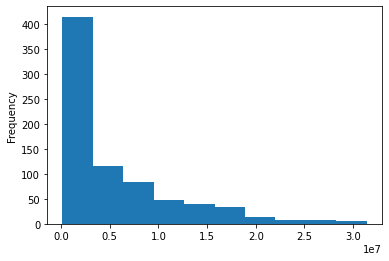

In [212]:
cleaned_df[cleaned_df['nationality'] == 'Brazil']['release_clause_eur'].plot(kind='hist')

In [213]:
stats.shapiro(cleaned_df[cleaned_df['nationality'] == 'Brazil']['release_clause_eur'])

ShapiroResult(statistic=0.7882118225097656, pvalue=1.9938501960568438e-30)

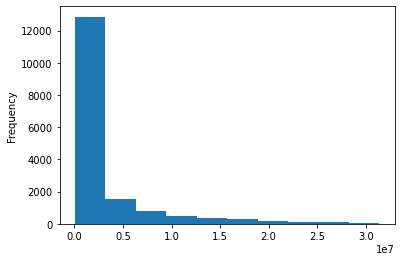

In [214]:
cleaned_df[cleaned_df['nationality'] != 'Brazil']['release_clause_eur'].plot(kind='hist')

In [215]:
stats.shapiro(cleaned_df[cleaned_df['nationality'] != 'Brazil']['release_clause_eur'])
#novamente percebemos que não se tratam de distribuições normais

/usr/local/lib/python3.7/dist-packages/scipy/stats/morestats.py:1760: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


ShapiroResult(statistic=0.6045077443122864, pvalue=0.0)

In [216]:
stats.mannwhitneyu(cleaned_df[cleaned_df['nationality'] == 'Brazil']['release_clause_eur'], cleaned_df[cleaned_df['nationality'] != 'Brazil']['release_clause_eur'], alternative ='greater')
#Ao fazermos o teste de hipótese, percebemos que, na média, o jogador brasileiro tem uma cláusula de rescisão contrtual mais cara que a média dos jogadores estrangeiros

MannwhitneyuResult(statistic=8918179.0, pvalue=3.2811386359659568e-71)

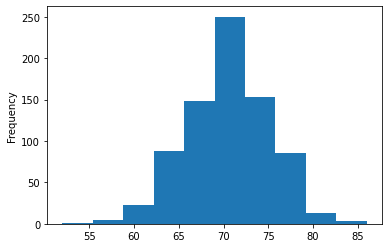

In [217]:
cleaned_df[cleaned_df['nationality'] == 'Brazil']['overall'].plot(kind='hist')

In [218]:


stats.shapiro(cleaned_df[cleaned_df['nationality'] == 'Brazil']['overall'])

ShapiroResult(statistic=0.9941365122795105, pvalue=0.004420362878590822)

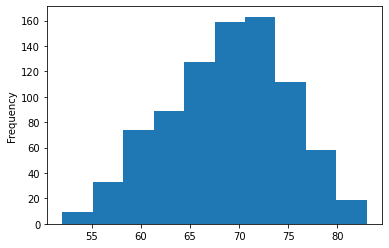

In [219]:
cleaned_df[cleaned_df['nationality'] == 'Argentina']['overall'].plot(kind='hist')

In [220]:
stats.shapiro(cleaned_df[cleaned_df['nationality'] == 'Argentina']['overall'])
#apesar dos gráfico se assemelharem a distribuições normais, percebemos que na verdade não são

ShapiroResult(statistic=0.9861823916435242, pvalue=3.8760828147133e-07)

In [221]:
import statistics
#verificaremos a hipótese do jogador brasileiro(18) ter, em média, um overall maior que o argentino(5)
print(statistics.mean(cleaned_df[cleaned_df['nationality'] == 'Brazil']['overall']))
print(statistics.mean(cleaned_df[cleaned_df['nationality'] == 'Argentina']['overall']))

70.41222366710014
68.75207591933571


In [222]:
from scipy import stats
#Ao fazermos o teste de hipótese, percebemos que o jogador brasileiro é de fato, em média, melhor que o argentinno
stats.mannwhitneyu(cleaned_df[cleaned_df['nationality'] == 'Brazil']['overall'], cleaned_df[cleaned_df['nationality'] == 'Argentina']['overall'], alternative ='greater')

MannwhitneyuResult(statistic=372920.0, pvalue=8.252010543980604e-08)